In [1]:
# importing all the library which are needed to do this projects

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import os


In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size 

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
# now we will set the dataset in the variable of name DIRECTORY

Directory = r"C:\\Users\\tejes\\Downloads\\archive (4)\\data"
Categories = ["with_mask","without_mask"]

In [4]:
data = []
labels = []

for c in Categories:
    path = os.path.join(Directory,c)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = load_img(img_path,target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(c)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)




c:\Users\tejes\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
data = np.array(data,dtype="float32")
labels = np.array(labels)

In [6]:
print(data)

[[[[-0.5529412  -0.5058824  -0.7254902 ]
   [-0.6392157  -0.5686275  -0.78039217]
   [-0.654902   -0.5764706  -0.7647059 ]
   ...
   [-0.6862745  -0.654902   -0.7882353 ]
   [-0.7647059  -0.7176471  -0.92156863]
   [-0.7176471  -0.6784314  -0.85882354]]

  [[-0.6        -0.5529412  -0.75686276]
   [-0.64705884 -0.58431375 -0.77254903]
   [-0.6392157  -0.56078434 -0.7490196 ]
   ...
   [-0.49019605 -0.4588235  -0.5764706 ]
   [-0.81960785 -0.75686276 -0.94509804]
   [-0.70980394 -0.64705884 -0.8117647 ]]

  [[-0.62352943 -0.5764706  -0.78039217]
   [-0.6392157  -0.5764706  -0.7647059 ]
   [-0.62352943 -0.54509807 -0.73333335]
   ...
   [-0.6        -0.5529412  -0.6627451 ]
   [-0.827451   -0.7647059  -0.92941177]
   [-0.7019608  -0.6313726  -0.78039217]]

  ...

  [[-0.54509807 -0.42745095 -0.73333335]
   [-0.54509807 -0.4352941  -0.7176471 ]
   [-0.54509807 -0.4588235  -0.70980394]
   ...
   [-0.8980392  -0.92941177 -0.9372549 ]
   [-0.88235295 -0.9137255  -0.92156863]
   [-0.8745098  

In [7]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
trainX,testX,trainY,testY = train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=42)
aug = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = "nearest"
)

In [9]:
# now we are going to load the mode "MobileNet" esuring the head FC LAYER sets are 
# left off

baseModel = MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

# Now we will construct the head of the model that wil be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)

model = Model(inputs = baseModel.input,outputs=headModel)



In [14]:
import tensorflow as tf
for layer in baseModel.layers:
	layer.trainable = False

import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9597WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 47 batches). You may need to use the repeat() function when building your dataset.


188/188 [==============================] - 164s 857ms/step - loss: 0.1308 - accuracy: 0.9597 - val_loss: 0.0904 - val_accuracy: 0.9749
Epoch 2/20
188/188 [==============================] - 138s 735ms/step - loss: 0.0657 - accuracy: 0.9774
Epoch 3/20
188/188 [==============================] - 223s 1s/step - loss: 0.0613 - accuracy: 0.9804
Epoch 4/20
188/188 [==============================] - 138s 732ms/step - loss: 0.0625 - accuracy: 0.9797
Epoch 5/20
188/188 [==============================] - 156s 828ms/step - loss: 0.0556 - accuracy: 0.9817
Epoch 6/20
188/188 [==============================] - 135s 714ms/step - loss: 0.0592 - accuracy: 0.9795
Epoch 7/20
188/188 [==============================] - 148s 784ms/step - loss: 0.0690 - accuracy: 0.9759
Epoch 8/20
188/188 [==============================] - 138s 730ms/step - loss: 0.0588 - accuracy: 0.9810
Epoch 9/20
188/188 [==============================] - 142s 757ms/step - loss: 0.0511 - accuracy: 0.9814
Epoch 10/20
188/188 [===============

In [15]:
pred = model.predict(testX,batch_size=BS)
pred = np.argmax(pred,axis=1)

print(classification_report(testY.argmax(axis=1),pred,target_names=lb.classes_))
model.save("mask_detector.model",save_format="h5")


48/48 [==============================] - 30s 597ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       745
without_mask       0.99      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



c:\Users\tejes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


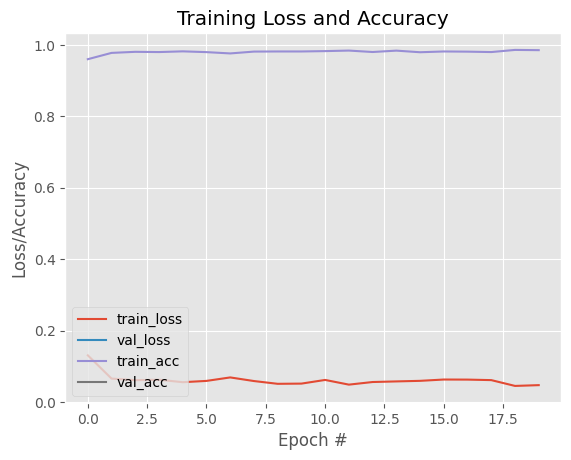

In [28]:
# plot the training loss and acuracy 
import matplotlib.pyplot as plt
N = EPOCHS
plt.style.use("ggplot")
plt.figure()

# Ensure consistent data length using slicing
plt.plot(np.arange(0, N)[:len(H.history["loss"])], H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N)[:len(H.history["val_loss"])], H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N)[:len(H.history["accuracy"])], H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N)[:len(H.history["val_accuracy"])], H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
